In [1]:
# !ollama pull llava:7b-v1.6-mistral-q4_0
# !ollama list



In [2]:
# !pip show transformers accelerate torch torchvision
# %pip install sentencepiece safetensors
# %pip install -U langchain-huggingface
# setx HF_HUB_DISABLE_SYMLINKS_WARNING 1


0.18.14


In [11]:
from unstructured.partition.pdf import partition_pdf
from langchain_core.runnables import RunnableLambda,RunnablePassthrough
from langchain.chat_models import ChatOpenAI
from langchain.schema import StrOutputParser
from langchain.prompts import ChatPromptTemplate
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
import pickle

from unstructured.documents.elements import (
    CoordinatesMetadata,
    Element,
    ElementMetadata,
    ElementType,
    Image,
    Link,
    ListItem,
    PageBreak,
    Text,
    Title,
)

In [3]:
from unstructured.partition.pdf import partition_pdf

elements = partition_pdf("./RAG4_MBBS_MM/attention.pdf", strategy="hi_res")

for el in elements:
    if el.metadata.coordinates:
        print(el.category, el.metadata.page_number, el.metadata.coordinates)



CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


UncategorizedText 1 CoordinatesMetadata(points=((45.388888888888886, 594.2222222222224), (45.388888888888886, 622.0000000000002), (100.94444444444446, 622.0000000000002), (100.94444444444446, 594.2222222222224)), system=<unstructured.documents.coordinates.PixelSpace object at 0x0000022BE74B11F0>)
UncategorizedText 1 CoordinatesMetadata(points=((51.0, 599.0), (51.0, 703.0), (88.0, 703.0), (88.0, 599.0)), system=<unstructured.documents.coordinates.PixelSpace object at 0x0000022B80BB24E0>)
UncategorizedText 1 CoordinatesMetadata(points=((45.388888888888886, 622.0000000000002), (45.388888888888886, 649.7777777777779), (100.94444444444446, 649.7777777777779), (100.94444444444446, 622.0000000000002)), system=<unstructured.documents.coordinates.PixelSpace object at 0x0000022BE74B1D00>)
UncategorizedText 1 CoordinatesMetadata(points=((45.388888888888886, 649.7777777777779), (45.388888888888886, 677.5555555555558), (100.94444444444446, 677.5555555555558), (100.94444444444446, 649.7777777777779)

In [ ]:
raw_pdf_element = partition_pdf(
    filename="./RAG4_MBBS_MM/attention.pdf",
    strategy="hi_res",
    extract_images_in_pdf=True,
    extract_image_block_types=["Image","Table"],
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="./RAG4_MBBS_MM/02/extracted_data/",
    # CoordinatesMetadata:True
    
)

In [3]:


# with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\raw_pdf_element.pkl", "wb") as f:
#     pickle.dump(raw_pdf_element, f)

with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\raw_pdf_element.pkl", "rb") as f:
    raw_pdf_element = pickle.load(f)



In [6]:
raw_pdf_element ,len(raw_pdf_element)

([<unstructured.documents.elements.Text at 0x1cc9f692900>,
 220)

In [ ]:
# Paste-and-run diagnostic + visualization (single page)
import fitz                     # pip install pymupdf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict

def collect_page_elements(elements, page_num):
    return [e for e in elements if getattr(e.metadata, "page_number", None) == page_num + 1]

def flatten_points(pts):
    return [(float(x), float(y)) for x, y in pts]

def page_diagnostics(pdf_path, elements, page_num=0, show_first_n=8):
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    pix = page.get_pixmap(alpha=False)
    print(f"PAGE DIAG - Page {page_num}:")
    print(f"  fitz page rect (pts): width={page.rect.width:.3f}, height={page.rect.height:.3f}")
    print(f"  rendered pix: width={pix.width}, height={pix.height}")
    page_elements = collect_page_elements(elements, page_num)
    print(f"  elements on page: {len(page_elements)}")
    seen_sys = {}
    for i, el in enumerate(page_elements[:show_first_n], start=1):
        coords = getattr(el.metadata, "coordinates", None)
        sys_name = type(coords.system).__name__ if coords else None
        print(f"  #{i}: category={el.category}, coord-system={sys_name}, has_coords={bool(coords)}")
        if coords:
            pts = coords.points
            print(f"      sample raw pts[0] = {pts[0]}")
            # print any metadata image_path / image_base64 if present
            ip = getattr(el.metadata, "image_path", None)
            if ip:
                print(f"      metadata.image_path = {ip}")
    doc.close()
    return

def apply_transform(pts, method, page_rect, pix, max_coords):
    # pts: list of (x,y) floats
    # method: one of the names below
    w_pix, h_pix = pix.width, pix.height
    w_pdf, h_pdf = page_rect.width, page_rect.height
    max_x, max_y = max_coords
    if method == "pixel":
        return pts
    if method == "pixel_flip":
        return [(x, h_pix - y) for x, y in pts]
    if method == "normalized":
        return [(x * w_pix, y * h_pix) for x, y in pts]
    if method == "pdf_points":
        return [(x * w_pix / w_pdf, h_pix - (y * h_pix / h_pdf)) for x, y in pts]
    if method == "adaptive":
        sx = w_pix / max_x if max_x > 0 else 1
        sy = h_pix / max_y if max_y > 0 else 1
        return [(x * sx, y * sy) for x, y in pts]
    if method == "adaptive_flip":
        sx = w_pix / max_x if max_x > 0 else 1
        sy = h_pix / max_y if max_y > 0 else 1
        return [(x * sx, h_pix - (y * sy)) for x, y in pts]
    raise ValueError("unknown method")

def score_in_bounds(polys, w_pix, h_pix):
    # simple score: fraction of polygon vertices that fall inside image for all polygons
    total = 0
    inside = 0
    for poly in polys:
        for x, y in poly:
            total += 1
            if 0 <= x <= w_pix and 0 <= y <= h_pix:
                inside += 1
    return (inside / total) if total else 0.0

def visualize_methods(pdf_path, elements, page_num=0, out_png=None, debug=True):
    doc = fitz.open(pdf_path)
    page = doc[page_num]
    pix = page.get_pixmap(alpha=False)
    pil_base = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    page_elements = collect_page_elements(elements, page_num)

    # gather all coords to compute adaptive scaling
    all_pts = []
    for el in page_elements:
        coords = getattr(el.metadata, "coordinates", None)
        if coords:
            all_pts.extend(flatten_points(coords.points))
    max_x = max((x for x, y in all_pts), default=1.0)
    max_y = max((y for x, y in all_pts), default=1.0)

    methods = ["pixel", "pixel_flip", "pdf_points", "normalized", "adaptive", "adaptive_flip"]
    cols = 3
    rows = (len(methods) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten()

    method_scores = {}
    for idx, method in enumerate(methods):
        im = pil_base.copy()
        draw = ImageDraw.Draw(im, "RGBA")
        transformed_polys = []
        for el in page_elements:
            coords = getattr(el.metadata, "coordinates", None)
            if not coords:
                continue
            pts = flatten_points(coords.points)
            pts_t = apply_transform(pts, method, page.rect, pix, (max_x, max_y))
            transformed_polys.append(pts_t)
            # draw polygon outline
            draw.line(pts_t + [pts_t[0]], fill=(255,0,0,200), width=3)
            # label
            xs = [p[0] for p in pts_t]; ys = [p[1] for p in pts_t]
            minx, miny = min(xs), min(ys)
            draw.rectangle([minx, miny-2, minx+80, miny+14], fill=(255,255,255,200))
            draw.text((minx+2, miny), el.category[:12], fill=(0,0,0,255))

        score = score_in_bounds(transformed_polys, pix.width, pix.height)
        method_scores[method] = score

        ax = axes[idx]
        ax.imshow(im)
        ax.set_title(f"{method} (score={score:.3f})")
        ax.axis("off")

    # hide any extra axes
    for j in range(len(methods), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    if out_png:
        fig.savefig(out_png, bbox_inches="tight", dpi=150)
        if debug:
            print("Saved diagnostics image:", out_png)
    plt.show()
    doc.close()

    # recommendation
    best_method = max(method_scores, key=method_scores.get)
    if debug:
        print("Method scores (higher is better):")
        for m, s in method_scores.items():
            print(f"  {m}: {s:.4f}")
        print("Suggested best method:", best_method)
    return best_method, method_scores

# -------------------------
# USAGE:
# 1) make sure 'elements' is from partition_pdf(..., strategy="hi_res")
# 2) run diagnostics and viz on the page you want (page 0 = first)
#
# Example:
# elements = partition_pdf("attention.pdf", strategy="hi_res", ocr_languages="eng")
# page_diagnostics("attention.pdf", elements, page_num=0)
# best, scores = visualize_methods("attention.pdf", elements, page_num=0, out_png="diag_page0.png")

# The function will show a 2x3 grid of overlays. The "best" method is suggested by a simple score.
# -------------------------


In [ ]:
elements = partition_pdf(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\attention.pdf", strategy="hi_res", ocr_languages="eng")
page_diagnostics(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\attention.pdf", elements, page_num=0)



The ocr_languages kwarg will be deprecated in a future version of unstructured. Please use languages instead.
Only one of languages and ocr_languages should be specified. languages is preferred. ocr_languages is marked for deprecation.
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox

PAGE DIAG - Page 0:
  fitz page rect (pts): width=612.000, height=792.000
  rendered pix: width=612, height=792
  elements on page: 36
  #1: category=UncategorizedText, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (45.388888888888886, 594.2222222222224)
  #2: category=UncategorizedText, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (51.0, 599.0)
  #3: category=UncategorizedText, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (45.388888888888886, 622.0000000000002)
  #4: category=UncategorizedText, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (45.388888888888886, 649.7777777777779)
  #5: category=UncategorizedText, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (45.388888888888886, 677.5555555555558)
  #6: category=Header, coord-system=PixelSpace, has_coords=True
      sample raw pts[0] = (45.388888888888886, 719.2222222222224)
  #7: category=UncategorizedText, coord-system=PixelSpac

FileNotFoundError: no such file: 'attention.pdf'

Saved diagnostics image: diag_page0.png


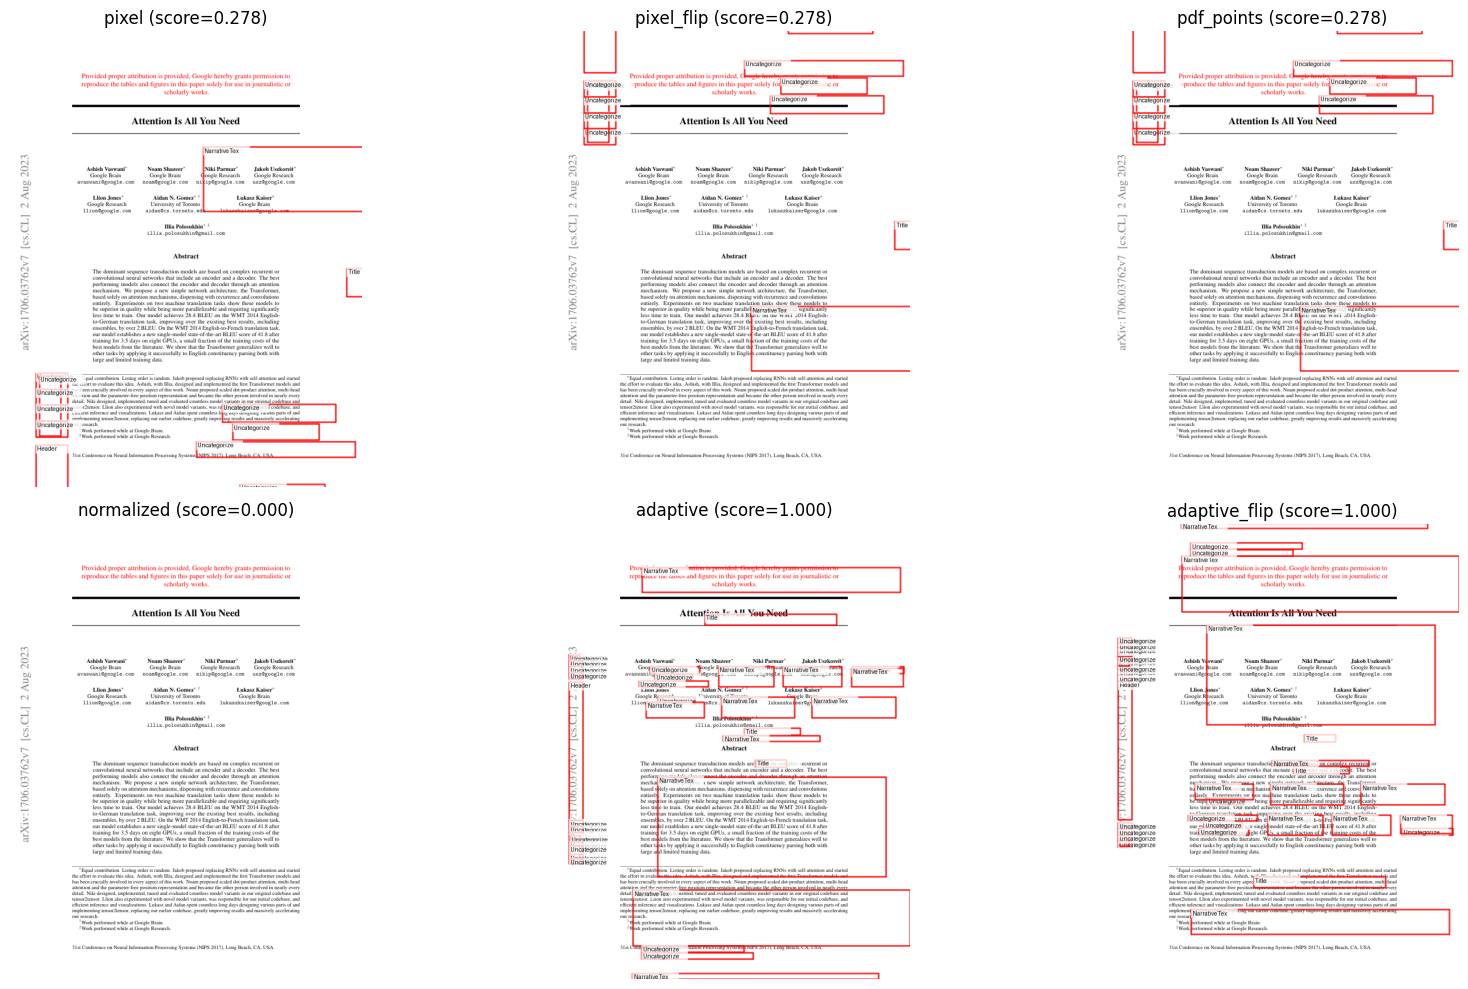

Method scores (higher is better):
  pixel: 0.2778
  pixel_flip: 0.2778
  pdf_points: 0.2778
  normalized: 0.0000
  adaptive: 1.0000
  adaptive_flip: 1.0000
Suggested best method: adaptive


In [13]:
best, scores = visualize_methods(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\attention.pdf", elements, page_num=0, out_png="diag_page0.png")

In [10]:
# To see all available attributes
import pprint

pprint.pprint(vars(raw_pdf_element[0].metadata))



{'_known_field_names': frozenset({'attached_to_filename',
                                  'bcc_recipient',
                                  'category_depth',
                                  'cc_recipient',
                                  'coordinates',
                                  'data_source',
                                  'detection_class_prob',
                                  'detection_origin',
                                  'email_message_id',
                                  'emphasized_text_contents',
                                  'emphasized_text_tags',
                                  'file_directory',
                                  'filename',
                                  'filetype',
                                  'header_footer_type',
                                  'image_base64',
                                  'image_mime_type',
                                  'image_path',
                                  'image_url',
       

In [4]:
raw_pdf_element[:5]

In [ ]:
Header=[]
Footer=[]
Title=[]
NarrativeText=[]
Text=[]
ListItem=[]

for element in raw_pdf_element:
    
    if "unstructured.documents.elements.Header" in str(type(element)):
        Header.append(str(element))
        
    elif "unstructured.documents.elements.Footer" in str(type(element)):
        Footer.append(str(element))
        
    elif "unstructured.documents.elements.Title" in str(type(element)):
        Title.append(str(element))
        
    elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
        NarrativeText.append(str(element))
        
    elif "unstructured.documents.elements.Text" in str(type(element)):
        Text.append(str(element))
        
    elif "unstructured.documents.elements.ListItem" in str(type(element)):
        ListItem.append(str(element))
        
        


In [ ]:
len(Header),len(Footer),len(Title),len(NarrativeText),len(Text),len(ListItem)

(3, 8, 27, 81, 37, 43)

In [ ]:
Image = []

for element in raw_pdf_element:
    if "unstructured.documents.elements.Image" in str(type(element)):
        Image.append(str(element))

In [ ]:
Table = []

for element in raw_pdf_element:
    if "unstructured.documents.elements.Table" in str(type(element)):
        Table.append(str(element))

In [ ]:
Table[0]

'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)'

In [ ]:
Image[0]

'Output Probabilities Add & Norm Feed Forward Add & Norm Multi-Head Attention a, Add & Norm Add & Norm Feed Forward Nx | -+CAgc8 Norm) Add & Norm Masked Multi-Head Multi-Head Attention Attention Se a, ee a, Positional Positional Encoding @ © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)'

In [ ]:


# with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\Narrative_Text_summaries.pkl", "wb") as f:
#     pickle.dump(Narrative_Text_summaries, f)


# with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\Table_summaries.pkl", "wb") as f:
#     pickle.dump(table_summaries, f)

with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\Narrative_Text_summaries.pkl", "rb") as f:
    Narrative_Text_summaries = pickle.load(f)
    

with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\Table_summaries.pkl", "rb") as f:
    table_summaries = pickle.load(f)
    

with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\images_b64.pkl", "rb") as f:
    image_b64 = pickle.load(f)


with open(r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\Pickle_data_and_summary\Image_summaries.pkl", "rb") as f:
    image_summaries = pickle.load(f)


In [2]:
import requests
import base64

class LocalLLaVAClient:
    """Client to interact with local LLaVA model"""

    def __init__(self, base_url="http://localhost:11434", model_name="llava:7b-v1.6-mistral-q4_0"):
        self.base_url = base_url
        self.model_name = model_name

    def analyze_image(self, image_data, prompt="Describe this image in detail."):
        """Analyze image using local LLaVA model"""
        try:
            # Prepare the request for Ollama API
            # The image_data should be a base64 encoded string
            payload = {
                "model": self.model_name,
                "prompt": prompt,
                "images": [image_data],
                "stream": False
            }

            response = requests.post(
                f"{self.base_url}/api/generate",
                json=payload,
                timeout=300  # Increased timeout to prevent errors
            )

            if response.status_code == 200:
                result = response.json()
                return result.get('response', 'No description available')
            else:
                print(f"LLaVA API error: {response.status_code} - {response.text}")
                return f"[ERROR: Could not analyze image - API returned {response.status_code}]"

        except requests.exceptions.ConnectionError:
            return "[ERROR: Could not connect to local LLaVA model. Is Ollama running?]"
        except Exception as e:
            print(f"LLaVA analysis error: {e}")
            return f"[ERROR: Image analysis failed - {str(e)}]"

In [11]:
image_summaries[:5]

[' The image appears to be a screenshot of a computer interface displaying various tables or databases with lines connecting different cells, which suggests a network or relationship between data elements. Each cell contains text and some cells have icons or colored bars next to them. The central part of the interface seems to highlight certain entries, possibly indicating selected items or nodes within this network. The overall layout is typical for a software application used for database management or analysis. ',
 ' The image shows a flowchart with labeled nodes connected by arrows, indicating a workflow or process diagram. It includes various stages such as "Begin," "Task," and "End," along with decision points like "If." The flowchart appears to be a representation of a structured task sequence, possibly from a business or organizational context. ',
 ' The image displays a word cloud with various words, some in bold typeface. The words are associated with different phrases and ap

In [41]:
file_path =r"D:\web dev backup\Pytorch\RAG4_MBBS_MM\attention.pdf"

In [43]:
import fitz 
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
from typing import List

def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)  # Fixed: was "as.imshow"
    
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato"
    }
    
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)  # Fixed: was pix_width/pix_height
            for x, y in points
        ]
        
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)
    
    # Fixed: moved legend creation outside the loop and fixed syntax
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]  # Fixed: was label:"Text"
    
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()

def render_page(doc_list: List, page_number: int, file_path: str, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

In [48]:
# First, check what's in raw_pdf_element[1]
print("Element 1 type:", type(raw_pdf_element[1]))
print("Element 1 metadata:", raw_pdf_element[1].metadata)

# Check if orig_elements exists and is not None
if hasattr(raw_pdf_element[1].metadata, 'orig_elements') and raw_pdf_element[1].metadata.orig_elements is not None:
    print("orig_elements exists and is not None")
    print("Length of orig_elements:", len(raw_pdf_element[1].metadata.orig_elements))
    
    if len(raw_pdf_element[1].metadata.orig_elements) > 0:
        print("First orig_element:", raw_pdf_element[1].metadata.orig_elements[0])
        print("Type of first orig_element:", type(raw_pdf_element[1].metadata.orig_elements[0]))
    else:
        print("orig_elements is empty")
else:
    print("orig_elements either doesn't exist or is None")

Element 1 type: <class 'unstructured.documents.elements.Text'>
Element 1 metadata: <unstructured.documents.elements.ElementMetadata object at 0x000002231B17FC50>
orig_elements either doesn't exist or is None


In [49]:
# For raw elements, just access the metadata directly
print("Raw element metadata:", raw_pdf_element[1].metadata.__dict__)

# Or if you want the element's own dictionary:
if hasattr(raw_pdf_element[1], 'to_dict'):
    print("Element dict:", raw_pdf_element[1].to_dict())
elif hasattr(raw_pdf_element[1], '__dict__'):
    print("Element dict:", raw_pdf_element[1].__dict__)

Raw element metadata: {'_known_field_names': frozenset({'page_number', 'bcc_recipient', 'is_continuation', 'page_name', 'links', 'header_footer_type', 'emphasized_text_contents', 'signature', 'table_as_cells', 'coordinates', 'last_modified', 'filename', 'orig_elements', 'url', 'file_directory', 'detection_origin', 'attached_to_filename', 'text_as_html', 'image_mime_type', 'image_url', 'image_base64', 'emphasized_text_tags', 'sent_from', 'link_texts', 'subject', 'sent_to', 'filetype', 'key_value_pairs', 'link_urls', 'link_start_indexes', 'email_message_id', 'data_source', 'parent_id', 'category_depth', 'cc_recipient', 'languages', 'detection_class_prob', 'image_path'}), 'coordinates': CoordinatesMetadata(points=((51.0, 599.0), (51.0, 703.0), (88.0, 703.0), (88.0, 599.0)), system=<unstructured.documents.coordinates.PixelSpace object at 0x000002231B17FD70>), 'links': [], 'last_modified': '2025-08-28T13:07:15', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'file_di

In [50]:
# since we are using chunking, we get raw_pdf_element of related documents
# since we selected "by_title" as the chunking strategy, we get sections of the document based on their title
for i, chunk in enumerate(raw_pdf_element):
    if "CompositeElement" in str(type(chunk)):
        print(f"\n\nChunk {i}")
        for doc in chunk.metadata.orig_elements:
            print(doc.to_dict()["type"], doc.metadata.page_number)

In [ ]:
# raw_pdf_element[1].metadata.orig_elements[0].dict

TypeError: 'NoneType' object is not subscriptable

In [56]:
from langchain_core.documents import Document

def extract_page_numbers_from_chunk(chunk):
    # Check if chunk has orig_elements (only chunked/composite elements have this)
    if hasattr(chunk.metadata, 'orig_elements') and chunk.metadata.orig_elements is not None:
        elements = chunk.metadata.orig_elements
    else:
        # If it's a raw element, treat it as a single element
        elements = [chunk]
    
    page_numbers = set()
    for element in elements:
        page_numbers.add(element.metadata.page_number)
    
    return page_numbers

def display_chunk_pages(chunk, file_path):  # Added file_path parameter
    """Display all pages that belong to a specific chunk with bounding boxes for ONLY that chunk's elements"""
    
    # Extract page numbers from the chunk
    page_numbers = extract_page_numbers_from_chunk(chunk)
    
    # Create documents list for visualization - ONLY elements from this chunk
    docs = []
    
    # Handle both chunked and raw elements
    if hasattr(chunk.metadata, 'orig_elements') and chunk.metadata.orig_elements is not None:
        elements = chunk.metadata.orig_elements
    else:
        elements = [chunk]
    
    for element in elements:
        metadata = element.metadata.to_dict()
        if "Table" in str(type(element)):
            metadata["category"] = "Table"
        elif "Image" in str(type(element)):
            metadata["category"] = "Image"
        else:
            metadata["category"] = "Text"
        metadata["page_number"] = int(element.metadata.page_number)
        
        # Handle different text attributes
        text_content = ""
        if hasattr(element, 'text'):
            text_content = element.text
        elif hasattr(element, 'page_content'):
            text_content = element.page_content
        else:
            text_content = str(element)
        
        docs.append(Document(page_content=text_content, metadata=metadata))
    
    # Render each page showing ONLY this chunk's elements
    for page_number in page_numbers:
        print(f"\n=== PAGE {page_number} - CHUNK ELEMENTS ONLY ===")
        render_page_chunk_only(docs, page_number, file_path, chunk_elements=docs)

def render_page_chunk_only(doc_list, page_number: int, file_path: str, chunk_elements, print_text=True) -> None:
    """Render a page showing only the elements from a specific chunk"""
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    
    # Filter to get only the chunk elements for this page
    page_docs = [
        doc for doc in chunk_elements if doc.metadata.get("page_number") == page_number
    ]
    
    print(f"Showing {len(page_docs)} elements from this chunk on page {page_number}")
    
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        print("\nText content from this chunk:")
        for i, doc in enumerate(page_docs, 1):
            print(f"{i}. {doc.page_content[:100]}...")

# Alternative function to show chunk vs all elements comparison
def compare_chunk_to_full_page(chunk, page_number, file_path):
    """Show side-by-side comparison of chunk elements vs all page elements"""
    
    # Get chunk elements
    if hasattr(chunk.metadata, 'orig_elements') and chunk.metadata.orig_elements is not None:
        elements = chunk.metadata.orig_elements
    else:
        elements = [chunk]
    
    chunk_docs = []
    for element in elements:
        if element.metadata.page_number == page_number:
            metadata = element.metadata.to_dict()
            if "Table" in str(type(element)):
                metadata["category"] = "Table"
            elif "Image" in str(type(element)):
                metadata["category"] = "Image"
            else:
                metadata["category"] = "Text"
            metadata["page_number"] = int(element.metadata.page_number)
            
            text_content = getattr(element, 'text', str(element))
            chunk_docs.append(Document(page_content=text_content, metadata=metadata))
    
    print(f"Chunk contains {len(chunk_docs)} elements on page {page_number}")
    
    # Show only chunk elements
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    segments = [doc.metadata for doc in chunk_docs]
    plot_pdf_with_boxes(pdf_page, segments)

# Fixed render_page function to include file_path parameter
def render_page(doc_list, page_number: int, file_path: str, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

# Usage examples:
# extract_page_numbers_from_chunk(raw_pdf_element[0])
# display_chunk_pages(raw_pdf_element[0], "./RAG4_MBBS_MM/attention.pdf")


=== PAGE 1 - CHUNK ELEMENTS ONLY ===
Showing 1 elements from this chunk on page 1


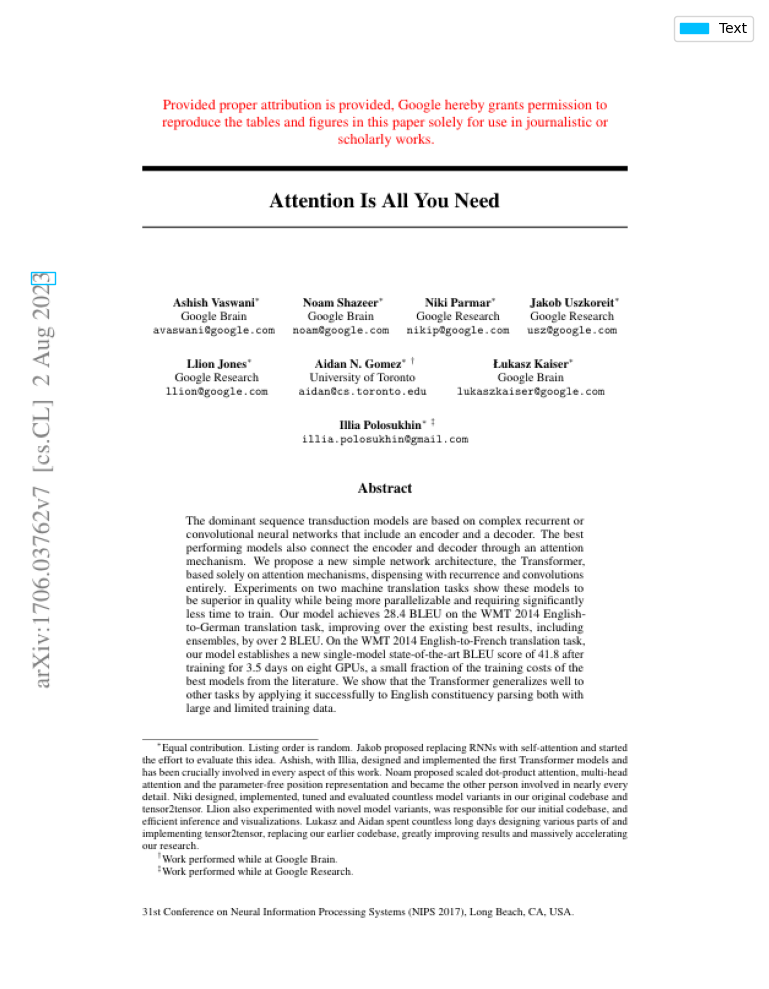


Text content from this chunk:
1. 3...

=== PAGE 1 - CHUNK ELEMENTS ONLY ===
Showing 1 elements from this chunk on page 1


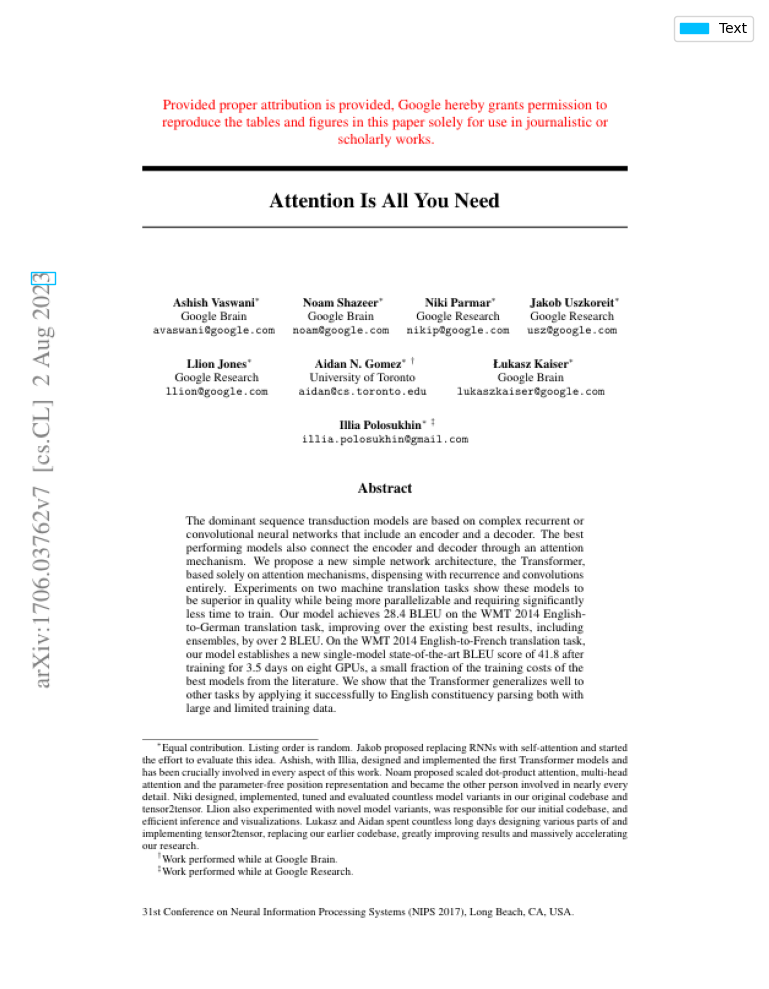


Text content from this chunk:
1. 3...


In [57]:
# For raw elements (no chunking)
page_nums = extract_page_numbers_from_chunk(raw_pdf_element[0])
display_chunk_pages(raw_pdf_element[0], "./RAG4_MBBS_MM/attention.pdf")

# For chunked elements (after applying chunking strategy)
# Test with your raw elements
display_chunk_pages(raw_pdf_element[0], "./RAG4_MBBS_MM/attention.pdf")

In [ ]:
# Add these imports at the top of your file
import requests
import json
import base64
from PIL import Image
import io

from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.schema import Document
import uuid
import base64
from typing import List, Dict, Any, Union


# Your existing embeddings
embeddings = HuggingFaceBgeEmbeddings(
    model_name="./bge-large-en-v1.5"
)


# Configuration class for content length and detail levels
class ContentConfig:
    """Configuration for content processing lengths and detail levels"""
    
    def __init__(self, 
                 text_max_length: int = 5000,
                 table_max_length: int = 3000,
                 image_description_detailed: bool = True,
                 include_continuation_markers: bool = True):
        
        self.text_max_length = text_max_length
        self.table_max_length = table_max_length
        self.image_description_detailed = image_description_detailed
        self.include_continuation_markers = include_continuation_markers
    
    @classmethod
    def create_detailed_config(cls):
        """Create config for maximum detail and length"""
        return cls(
            text_max_length=8000,      # Very long text
            table_max_length=5000,     # Long tables
            image_description_detailed=True,
            include_continuation_markers=True
        )
    
    @classmethod
    def create_moderate_config(cls):
        """Create config for moderate length"""
        return cls(
            text_max_length=3000,      # Moderate text
            table_max_length=2000,     # Moderate tables
            image_description_detailed=True,
            include_continuation_markers=True
        )
    
    @classmethod
    def create_compact_config(cls):
        """Create config for shorter content (original behavior)"""
        return cls(
            text_max_length=1000,      # Short text
            table_max_length=500,      # Short tables
            image_description_detailed=False,
            include_continuation_markers=False
        )


# Add this class to integrate with your local LLaVA model
class LocalLLaVAClient:
    """Client to interact with local LLaVA model"""
    
    def __init__(self, base_url="http://localhost:11434", model_name="llava:7b-v1.6-mistral-q4_0"):
        self.base_url = base_url
        self.model_name = model_name
    
    def analyze_image(self, image_data, prompt="Describe this medical image in detail, including any visible conditions, anatomical structures, or clinical findings."):
        """Analyze image using local LLaVA model"""
        try:
            # Prepare the request for Ollama API
            payload = {
                "model": self.model_name,
                "prompt": prompt,
                "images": [image_data] if isinstance(image_data, str) else [base64.b64encode(image_data).decode()],
                "stream": False
            }
            
            response = requests.post(
                f"{self.base_url}/api/generate",
                json=payload,
                timeout=60
            )
            
            if response.status_code == 200:
                result = response.json()
                return result.get('response', 'No description available')
            else:
                print(f"LLaVA API error: {response.status_code} - {response.text}")
                return f"[ERROR: Could not analyze image - API returned {response.status_code}]"
                
        except requests.exceptions.ConnectionError:
            return "[ERROR: Could not connect to local LLaVA model. Is Ollama running?]"
        except Exception as e:
            print(f"LLaVA analysis error: {e}")
            return f"[ERROR: Image analysis failed - {str(e)}]"

# Modified EnhancedMultiModalRetriever class
class EnhancedMultiModalRetriever:
    def __init__(self, vectorstore, embedding_function, content_config=None, use_local_llava=True):
        self.vectorstore = vectorstore
        self.store = InMemoryStore()
        self.id_key = 'doc_id'
        self.content_type_key = 'content_type'
        self.config = content_config or ContentConfig.create_detailed_config()
        
        # Initialize local LLaVA client
        self.use_local_llava = use_local_llava
        if use_local_llava:
            self.llava_client = LocalLLaVAClient()
            print("🔧 Local LLaVA model integration enabled")
        else:
            self.llava_client = None
            print("⚠️  Local LLaVA model integration disabled")
        
        self.retriever = MultiVectorRetriever(
            vectorstore=vectorstore,
            docstore=self.store,
            id_key=self.id_key
        )
    
    
    def get_relevant_documents(self, query: str, k: int = 4) -> List[Dict[str, Any]]:
        """Get relevant documents with proper content type handling"""
        
        # Get raw documents from retriever
        raw_docs = self.retriever.get_relevant_documents(query, k=k)
        print("raw_docs : ",raw_docs)
        
        processed_docs = []
        
        for doc in raw_docs:
            if isinstance(doc, dict):
                # Handle structured content
                content_type = doc.get('content_type', 'unknown')
                content = doc.get('content', '')
                
                processed_doc = {
                    'content_type': content_type,
                    'doc_id': doc.get('doc_id', 'unknown'),
                    'processed_content': self._process_content_by_type(content, content_type)
                }
                
            else:
                # Handle raw string content (fallback)
                processed_doc = {
                    'content_type': self._detect_content_type(str(doc)),
                    'doc_id': 'unknown',
                    'processed_content': self._process_raw_content(str(doc))
                }
            
            processed_docs.append(processed_doc)
            print("processed_doc : ",processed_doc)
        
        return processed_docs
    
    
    def add_documents_by_type(self, summaries: List[str], contents: List[Any], content_type: str):
        """Add documents with proper content type tracking and LLaVA analysis for images"""
        if not summaries or not contents:
            return
        
        # If adding images and LLaVA is enabled, analyze them first
        if content_type == 'image' and self.use_local_llava and self.llava_client:
            print(f"🖼️  Analyzing {len(contents)} images with local LLaVA model...")
            analyzed_summaries = []
            
            for i, (summary, image_content) in enumerate(zip(summaries, contents)):
                print(f"   Analyzing image {i+1}/{len(contents)}...")
                
                # Get LLaVA analysis
                llava_description = self.llava_client.analyze_image(
                    image_content,
                    "Analyze this medical image in detail. Describe any visible anatomical structures, pathological findings, medical devices, text, charts, or clinical information present."
                )
                
                # Combine original summary with LLaVA analysis
                enhanced_summary = f"{summary}\n\nLLaVA Analysis: {llava_description}"
                analyzed_summaries.append(enhanced_summary)
            
            summaries = analyzed_summaries
            print("✅ Image analysis complete")
            
        doc_ids = [str(uuid.uuid4()) for _ in contents]
        
        # Create summary documents with metadata
        summary_docs = [
            Document(
                page_content=summary, 
                metadata={
                    self.id_key: doc_ids[i],
                    self.content_type_key: content_type,
                    'summary': True
                }
            )
            for i, summary in enumerate(summaries)
        ]
        
        # Add summaries to vectorstore
        self.retriever.vectorstore.add_documents(summary_docs)
        
        # Store original content with metadata
        content_with_metadata = [
            {
                'content': content,
                'content_type': content_type,
                'doc_id': doc_ids[i]
            }
            for i, content in enumerate(contents)
        ]
        
        self.retriever.docstore.mset(list(zip(doc_ids, content_with_metadata)))

    def _process_content_by_type(self, content: Any, content_type: str) -> str:
        """Process content based on its type with LLaVA analysis for images"""
        
        if content_type == 'text':
            full_content = str(content)
            if len(full_content) > self.config.text_max_length:
                truncated = full_content[:self.config.text_max_length]
                if self.config.include_continuation_markers:
                    return truncated + "\n\n[Content continues with additional medical details...]"
                return truncated
            return full_content
            
        elif content_type == 'table':
            if isinstance(content, str):
                table_content = content
            else:
                table_content = str(content)
            
            if len(table_content) > self.config.table_max_length:
                truncated = table_content[:self.config.table_max_length]
                marker = "\n\n[Table continues with additional medical data...]" if self.config.include_continuation_markers else ""
                return f"[TABLE DATA - Medical/Clinical Information]:\n{truncated}{marker}"
            return f"[TABLE DATA - Complete Medical/Clinical Information]:\n{table_content}"
                
        elif content_type == 'image':
            # Use local LLaVA for real-time analysis if available
            if self.use_local_llava and self.llava_client:
                print("🔍 Analyzing image with local LLaVA model...")
                
                try:
                    # Get image data
                    image_data = content
                    if isinstance(content, str) and content.startswith('data:image'):
                        # Extract base64 data from data URI
                        image_data = content.split(',')[1]
                    
                    # Analyze with LLaVA
                    analysis = self.llava_client.analyze_image(
                        image_data,
                        "Provide a detailed medical analysis of this image, including any visible pathological findings, anatomical structures, or clinical information."
                    )
                    
                    return f"[MEDICAL IMAGE - LLaVA ANALYSIS]:\n{analysis}"
                    
                except Exception as e:
                    print(f"LLaVA analysis error: {e}")
                    return f"[MEDICAL IMAGE - ERROR]: Could not analyze with LLaVA - {str(e)}"
            
            # Fallback to original behavior
            if self.config.image_description_detailed:
                return """[MEDICAL IMAGE]: Local LLaVA analysis not available. Visual content present for manual analysis."""
            else:
                return "[IMAGE]: Medical image available"
                
        else:
            content_str = str(content)
            max_length = max(self.config.text_max_length, 2000)
            
            if len(content_str) > max_length:
                truncated = content_str[:max_length]
                marker = f"\n\n[{content_type.upper()} content continues...]" if self.config.include_continuation_markers else ""
                return f"[{content_type.upper()} - Detailed Medical Content]:\n{truncated}{marker}"
            return f"[{content_type.upper()} - Complete Medical Content]:\n{content_str}"

    # ... (rest of your existing methods remain the same)
    def _process_raw_content(self, content: str) -> str:
        """Process raw content when type is unknown - with longer format"""
        
        # Check if it's base64 image data
        if self._is_base64_image(content):
            return "[IMAGE]: Comprehensive medical image data available for detailed visual analysis by vision model. This contains clinical information that can be processed for medical insights."
        
        # Return longer text content for better context
        max_length = getattr(self.config, 'text_max_length', 4000)
        if len(content) > max_length:
            return content[:max_length] + "\n\n[Content continues for additional context...]"
        return content
    
    def _detect_content_type(self, content: str) -> str:
        """Detect content type from raw content"""
        
        if self._is_base64_image(content):
            return 'image'
        elif '|' in content and '\n' in content:  # Simple table detection
            return 'table'
        else:
            return 'text'
    
    def _is_base64_image(self, content: str) -> bool:
        """Check if content is base64 encoded image"""
        try:
            if isinstance(content, str):
                # Remove data URI prefix if present
                if content.startswith('data:image'):
                    content = content.split(',')[1]
                
                # Check if it looks like base64
                if len(content) > 100 and content.replace('/', '').replace('+', '').replace('=', '').isalnum():
                    # Try to decode to verify
                    base64.b64decode(content[:100])  # Just test first 100 chars
                    return True
        except:
            pass
        return False

# Updated factory function
import os
from pathlib import Path

def smart_create_retriever_custom_folder(
    text_summaries=None, texts=None,
    table_summaries=None, tables=None, 
    image_summaries=None, images=None,
    detail_level="detailed",
    use_local_llava=True,
    force_recreate=False,
    save_folder="./my_medical_retriever"  # ← Custom folder parameter
):
    """
    Smart retriever that saves to your custom folder
    
    Args:
        save_folder: Path where you want to save the retriever data
                    Examples: "./my_folder", "C:/my_data/retriever", "/home/user/data"
        Other args: Same as before
    """
    
    # Convert to Path object and create folder structure
    persist_dir = Path(save_folder)
    persist_dir.mkdir(parents=True, exist_ok=True)  # Creates nested folders if needed
    
    collection_name = f"mm_rag_enhanced_{detail_level}"
    
    print(f"📁 Using save folder: {persist_dir.absolute()}")
    
    # Check if vectorstore already exists
    vectorstore_exists = persist_dir.exists() and \
                        any(persist_dir.glob("*")) and \
                        not force_recreate
    
    if vectorstore_exists:
        print("🔍 Checking existing vectorstore...")
        
        try:
            vectorstore = Chroma(
                collection_name=collection_name,
                embedding_function=embeddings,
                persist_directory=str(persist_dir)  # Convert Path to string
            )
            
            # Check if it has documents
            collection = vectorstore._collection
            doc_count = collection.count()
            
            if doc_count > 0:
                print(f"✅ Found existing vectorstore with {doc_count} documents!")
                print(f"📂 Loaded from: {persist_dir.absolute()}")
                print("🚀 Loading existing retriever (no processing needed)...")
                
                # Create retriever with existing data
                config = ContentConfig.create_detailed_config() if detail_level == "detailed" else ContentConfig.create_moderate_config()
                
                retriever = EnhancedMultiModalRetriever(
                    vectorstore=vectorstore,
                    embedding_function=embeddings,
                    content_config=config,
                    use_local_llava=use_local_llava
                )
                
                print("⚡ Retriever loaded instantly - ready to query!")
                return retriever
            else:
                print("⚠️  Vectorstore exists but is empty, will recreate...")
                
        except Exception as e:
            print(f"⚠️  Error loading existing vectorstore: {e}")
            print("🔄 Will create new one...")
    
    # Create new retriever
    if force_recreate:
        print(f"🔄 Force recreating vectorstore in: {persist_dir.absolute()}")
    else:
        print(f"🆕 Creating new vectorstore in: {persist_dir.absolute()}")
    
    # Choose configuration
    if detail_level == "detailed":
        config = ContentConfig.create_detailed_config()
        print("🔧 Using DETAILED configuration (up to 8000 chars per document)")
    elif detail_level == "moderate":
        config = ContentConfig.create_moderate_config()  
        print("🔧 Using MODERATE configuration (up to 3000 chars per document)")
    elif detail_level == "compact":
        config = ContentConfig.create_compact_config()
        print("🔧 Using COMPACT configuration (up to 1000 chars per document)")
    else:
        config = ContentConfig.create_detailed_config()
        print("🔧 Using DEFAULT DETAILED configuration")
    
    # Create vectorstore in custom folder
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=str(persist_dir)
    )
    
    # Initialize enhanced retriever
    enhanced_retriever = EnhancedMultiModalRetriever(
        vectorstore, 
        embeddings, 
        config, 
        use_local_llava=use_local_llava
    )
    
    # Add different content types
    if text_summaries and texts:
        print(f"Adding {len(text_summaries)} text documents...")
        enhanced_retriever.add_documents_by_type(text_summaries, texts, 'text')
    
    if table_summaries and tables:
        print(f"Adding {len(table_summaries)} table documents...")
        enhanced_retriever.add_documents_by_type(table_summaries, tables, 'table')
    
    if image_summaries and images:
        print(f"Adding {len(image_summaries)} image documents with LLaVA analysis...")
        enhanced_retriever.add_documents_by_type(image_summaries, images, 'image')
    
    print(f"✅ Retriever created and saved to: {persist_dir.absolute()}")
    print(f"📊 Total folder size: {get_folder_size(persist_dir):.1f} MB")
    
    return enhanced_retriever

def get_folder_size(folder_path):
    """Calculate folder size in MB"""
    try:
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(folder_path):
            for filename in filenames:
                filepath = os.path.join(dirpath, filename)
                try:
                    total_size += os.path.getsize(filepath)
                except:
                    pass
        return total_size / (1024 * 1024)  # Convert to MB
    except:
        return 0

# Example usage with different folder options:

def demo_custom_folders():
    """Show different folder options"""
    
    print("📁 CUSTOM FOLDER OPTIONS:")
    print("=" * 50)
    
    # Option 1: Simple relative folder
    print("\n1️⃣  Simple folder in current directory:")
    print('   save_folder="./my_medical_data"')
    
    # Option 2: Nested folder
    print("\n2️⃣  Nested folder structure:")  
    print('   save_folder="./data/medical_retrievers/version_1"')
    
    # Option 3: Absolute path (Windows)
    print("\n3️⃣  Windows absolute path:")
    print('   save_folder="C:/Users/YourName/Documents/MedicalAI/retrievers"')
    
    # Option 4: Absolute path (Linux/Mac)
    print("\n4️⃣  Linux/Mac absolute path:")
    print('   save_folder="/home/username/medical_data/retrievers"')
    
    # Option 5: Different folders for different projects
    print("\n5️⃣  Project-specific folders:")
    print('   save_folder="./projects/cardiology_docs"')
    print('   save_folder="./projects/radiology_docs"')
    
    print("\n💡 The folder will be created automatically if it doesn't exist!")

demo_custom_folders()

# Ready-to-use examples:
print("\n🚀 READY TO USE:")
print("=" * 40)

print("\n📝 Example 1 - Simple custom folder:")
print('''
retriever_detailed = smart_create_retriever_custom_folder(
    text_summaries=Narrative_Text_summaries,
    texts=NarrativeText,
    table_summaries=table_summaries,
    tables=Table,
    image_summaries=image_summaries,
    images=[img["b64"] for img in image_b64],
    detail_level="detailed",
    use_local_llava=True,
    save_folder="./my_medical_retriever"  # Your custom folder!
)
''')

print("\n📝 Example 2 - Load from custom folder (next time):")
print('''
retriever_detailed = smart_create_retriever_custom_folder(
    detail_level="detailed",
    use_local_llava=True,
    save_folder="./my_medical_retriever"  # Same folder as before
)
''')

print("\n📝 Example 3 - Multiple projects:")
print('''
# Save different retrievers for different projects:
cardiology_retriever = smart_create_retriever_custom_folder(
    save_folder="./medical_data/cardiology",
    # ... your cardiology documents ...
)

radiology_retriever = smart_create_retriever_custom_folder(
    save_folder="./medical_data/radiology", 
    # ... your radiology documents ...
)
''')

print("\n✅ Custom folder retriever ready!")
print("🔧 Just change the save_folder parameter to your desired location!")
print("✅ Enhanced Multi-Modal Retriever with LOCAL LLAVA integration ready!")
print("🔧 Your llava:7b-v1.6-mistral-q4_0 model will now be used for image analysis!")

C:\Users\Bhavesh\AppData\Local\Temp\ipykernel_21040\2524847328.py:19: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(



📁 CUSTOM FOLDER OPTIONS:

1️⃣  Simple folder in current directory:
   save_folder="./my_medical_data"

2️⃣  Nested folder structure:
   save_folder="./data/medical_retrievers/version_1"

3️⃣  Windows absolute path:
   save_folder="C:/Users/YourName/Documents/MedicalAI/retrievers"

4️⃣  Linux/Mac absolute path:
   save_folder="/home/username/medical_data/retrievers"

5️⃣  Project-specific folders:
   save_folder="./projects/cardiology_docs"
   save_folder="./projects/radiology_docs"

💡 The folder will be created automatically if it doesn't exist!

🚀 READY TO USE:

📝 Example 1 - Simple custom folder:

retriever_detailed = smart_create_retriever_custom_folder(
    text_summaries=Narrative_Text_summaries,
    texts=NarrativeText,
    table_summaries=table_summaries,
    tables=Table,
    image_summaries=image_summaries,
    images=[img["b64"] for img in image_b64],
    detail_level="detailed",
    use_local_llava=True,
    save_folder="./my_medical_retriever"  # Your custom folder!
)


📝 

In [ ]:
def query_enhanced_retriever_detailed(retriever, query: str, k: int = 6):
    """Query with more results and detailed formatting"""
    
    print(f"🔍 Detailed Query: {query}")
    print("=" * 80)
    
    docs = retriever.get_relevant_documents(query, k=k)
    
    for i, doc in enumerate(docs, 1):
        print(f"\n📄 Document {i}/{len(docs)}:")
        print(f"🔸 Type: {doc['content_type']}")
        print(f"🔸 ID: {doc['doc_id']}")
        print(f"🔸 Content Length: {len(doc['processed_content'])} characters")
        print(f"🔸 Preview: {doc['processed_content'][:200]}...")
        print("-" * 60)
    
    print("docs : ",docs)
    return docs

def query_enhanced_retriever(retriever, query: str, k: int = 4):
    """Query the enhanced retriever with proper output formatting"""
    
    print(f"🔍 Query: {query}")
    print("=" * 60)
    
    docs = retriever.get_relevant_documents(query, k=k)
    
    for i, doc in enumerate(docs, 1):
        print(f"\n📄 Result {i}:")
        print(f"🔸 Type: {doc['content_type']}")
        print(f"🔸 ID: {doc['doc_id']}")
        print(f"🔸 Content: {doc['processed_content'][:300]}...")
        print("-" * 40)
    
    return docs

# For integration with your LLM - Enhanced for longer, detailed context:
def prepare_comprehensive_context_for_llm(docs: List[Dict[str, Any]], include_metadata: bool = True) -> str:
    """Prepare detailed, comprehensive context for LLM with longer content"""
    
    context_parts = []
    
    for i, doc in enumerate(docs, 1):
        content_type = doc['content_type']
        content = doc['processed_content']
        doc_id = doc.get('doc_id', 'unknown')
        
        # Create detailed section headers
        if content_type == 'text':
            header = f"=== MEDICAL TEXT DOCUMENT {i} ==="
            if include_metadata:
                header += f"\n[Document ID: {doc_id}]"
            context_parts.append(f"{header}\n{content}\n")
            
        elif content_type == 'table':
            header = f"=== MEDICAL TABLE/DATA {i} ==="
            if include_metadata:
                header += f"\n[Document ID: {doc_id}]"
            context_parts.append(f"{header}\n{content}\n")
            
        elif content_type == 'image':
            header = f"=== MEDICAL IMAGE/VISUAL {i} ==="
            if include_metadata:
                header += f"\n[Document ID: {doc_id}]"
            context_parts.append(f"{header}\n{content}\n")
    
    # Add comprehensive context header
    full_context = f"""
COMPREHENSIVE MEDICAL KNOWLEDGE BASE CONTEXT
============================================
Retrieved {len(docs)} relevant document(s) for detailed analysis.
Each document below contains medical information that should be used to provide thorough, accurate responses.

{chr(10).join(context_parts)}

ANALYSIS INSTRUCTIONS:
- Use ALL provided medical information for comprehensive responses
- Reference specific details from the documents above
- Provide detailed explanations when medical concepts are mentioned
- Consider relationships between different document types (text, tables, images)
============================================
"""
    
    print("context parts",context_parts)
    return full_context

def prepare_context_for_llm(docs: List[Dict[str, Any]]) -> str:
    """Prepare retrieved documents for LLM context - enhanced version"""
    return prepare_comprehensive_context_for_llm(docs, include_metadata=False)

print("✅ Enhanced Multi-Modal Retriever with ContentConfig ready!")
print("🔧 ContentConfig class is now properly defined")
print("📝 Use detail_level='detailed' for longer summaries (up to 8000 characters)")

# Test ContentConfig
try:
    test_config = ContentConfig.create_detailed_config()
    print(f"✅ ContentConfig test successful! Max text length: {test_config.text_max_length}")
except Exception as e:
    print(f"❌ ContentConfig error: {e}")

✅ Enhanced Multi-Modal Retriever with ContentConfig ready!
🔧 ContentConfig class is now properly defined
📝 Use detail_level='detailed' for longer summaries (up to 8000 characters)
✅ ContentConfig test successful! Max text length: 8000


In [ ]:
# Create custom configuration
custom_config = ContentConfig(
    text_max_length=10000,     # Even longer text!
    table_max_length=6000,     # Longer tables
    image_description_detailed=True,
    include_continuation_markers=True
)


In [ ]:

# Use with retriever
vectorstore = Chroma(collection_name="mm_rag_enhanced", embedding_function=embeddings)
retriever_custom = EnhancedMultiModalRetriever(vectorstore, embeddings, custom_config)

# Create retriever WITH LLaVA integration
retriever_detailed = smart_create_retriever_custom_folder(
    text_summaries=Narrative_Text_summaries,
    texts=NarrativeText,
    table_summaries=table_summaries,
    tables=Table,
    image_summaries=image_summaries,
    images=[img["b64"] for img in image_b64],
    detail_level="detailed",  # ← ADD COMMA HERE
    use_local_llava=True,
    save_folder="./my_medical_data"
)

# Now when you query, images will be analyzed with your local LLaVA model


C:\Users\Bhavesh\AppData\Local\Temp\ipykernel_10360\1528333170.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="mm_rag_enhanced", embedding_function=embeddings)


🔧 Local LLaVA model integration enabled
📁 Using save folder: d:\web dev backup\Pytorch\my_medical_data
🆕 Creating new vectorstore in: d:\web dev backup\Pytorch\my_medical_data
🔧 Using DETAILED configuration (up to 8000 chars per document)
🔧 Local LLaVA model integration enabled
Adding 81 text documents...
Adding 4 table documents...
Adding 11 image documents with LLaVA analysis...
🖼️  Analyzing 11 images with local LLaVA model...
   Analyzing image 1/11...
   Analyzing image 2/11...
   Analyzing image 3/11...
   Analyzing image 4/11...
LLaVA analysis error: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)
   Analyzing image 5/11...
LLaVA analysis error: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)
   Analyzing image 6/11...
LLaVA analysis error: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=60)
   Analyzing image 7/11...
   Analyzing image 8/11...
LLaVA analysis error: HTTPConnec

In [ ]:
from langchain.vectorstores import Chroma

# Same embedding function you used before
embeddings = HuggingFaceBgeEmbeddings(
    model_name="./all-MiniLM-L6-v2"
)

# Reload the vectorstore from the same folder
vectorstore = Chroma(
    collection_name="mm_rag_enhanced_detailed",  # must match the name used earlier
    embedding_function=embeddings,
    persist_directory="./my_medical_data"
)

# Now wrap it again in your EnhancedMultiModalRetriever
retriever_detailed = EnhancedMultiModalRetriever(vectorstore, embeddings,custom_config)

print("✅ Retriever reloaded from ./my_medical_data")


🔧 Local LLaVA model integration enabled
✅ Retriever reloaded from ./my_medical_data


In [ ]:
print("Docs in vectorstore:", vectorstore._collection.count())


Docs in vectorstore: 96


In [ ]:
query = "Whats scaled dot product?"
docs = retriever_detailed.get_relevant_documents(query, k=4)
context = prepare_comprehensive_context_for_llm(docs)

print(f"Context length: {len(context)} characters") 
print(context)

raw_docs :  []
context parts []
Context length: 598 characters


In [26]:
# Quick manual check of your folder
import os
from pathlib import Path

folder = Path("./my_medical_data")
if folder.exists():
    files = list(folder.glob("*"))
    print(f"✅ Folder exists with {len(files)} files")
    
    # Check if vectorstore works
    try:
        vectorstore = Chroma(
            collection_name="mm_rag_enhanced_detailed",
            embedding_function=embeddings,
            persist_directory="./my_medical_data"
        )
        doc_count = vectorstore._collection.count()
        print(f"📊 Vectorstore contains {doc_count} documents")
    except Exception as e:
        print(f"❌ Error loading: {e}")
else:
    print("❌ Folder doesn't exist yet")

✅ Folder exists with 2 files
📊 Vectorstore contains 96 documents


In [34]:
MODEL_NAME = "llava:7b-v1.6-mistral-q4_0 "

In [33]:
import os
import glob
from pathlib import Path
import fitz  # PyMuPDF
from PIL import Image
import pandas as pd
from docx import Document
import ollama
from typing import List, Dict, Any

class MedicalFolderProcessor:
    def __init__(self, model_name="llava:7b-v1.6-mistral-q4_0ma"):
        self.model_name = model_name
        self.supported_formats = {
            'pdf': ['.pdf'],
            'image': ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'],
            'document': ['.docx', '.txt'],
            'table': ['.xlsx', '.csv']
        }
    
    def scan_medical_folder(self, folder_path: str) -> Dict[str, List[str]]:
        """Scan folder and categorize medical files"""
        folder_path = Path(folder_path)
        
        if not folder_path.exists():
            print(f"❌ Folder not found: {folder_path}")
            return {}
        
        files_by_type = {
            'pdf': [],
            'image': [],
            'document': [],
            'table': []
        }
        
        print(f"🔍 Scanning folder: {folder_path}")
        
        # Scan all files recursively
        for file_path in folder_path.rglob('*'):
            if file_path.is_file():
                file_ext = file_path.suffix.lower()
                
                for file_type, extensions in self.supported_formats.items():
                    if file_ext in extensions:
                        files_by_type[file_type].append(str(file_path))
                        break
        
        # Print summary
        print("📊 Found files:")
        for file_type, files in files_by_type.items():
            if files:
                print(f"  📄 {file_type.upper()}: {len(files)} files")
        
        return files_by_type
    
    def process_pdf_file(self, pdf_path: str) -> Dict[str, Any]:
        """Process a single PDF file"""
        print(f"📄 Processing PDF: {os.path.basename(pdf_path)}")
        
        try:
            doc = fitz.open(pdf_path)
            results = {
                'text_summaries': [],
                'image_analyses': [],
                'file_path': pdf_path,
                'file_name': os.path.basename(pdf_path)
            }
            
            # Process first 5 pages to avoid memory issues
            max_pages = min(len(doc), 5)
            
            for page_num in range(max_pages):
                page = doc[page_num]
                
                # Extract text
                text = page.get_text()
                if text.strip():
                    # Summarize using Ollama
                    summary = self.summarize_with_ollama(text, f"medical content from {os.path.basename(pdf_path)} page {page_num+1}")
                    results['text_summaries'].append({
                        'page': page_num + 1,
                        'original_text': text,
                        'summary': summary
                    })
                
                # Extract images (limit to 2 per page)
                images = page.get_images()[:2]
                for img_index, img in enumerate(images):
                    try:
                        xref = img[0]
                        pix = fitz.Pixmap(doc, xref)
                        if pix.n - pix.alpha < 4:
                            # Save temp image
                            temp_path = f"temp_{page_num}_{img_index}.png"
                            pix.save(temp_path)
                            
                            # Analyze with Ollama
                            analysis = self.analyze_image_with_ollama(temp_path)
                            results['image_analyses'].append({
                                'page': page_num + 1,
                                'analysis': analysis,
                                'image_data': f"page_{page_num}_img_{img_index}"
                            })
                            
                            # Clean up
                            os.remove(temp_path)
                        pix = None
                    except Exception as e:
                        print(f"  ⚠️ Image error on page {page_num+1}: {e}")
            
            doc.close()
            return results
            
        except Exception as e:
            print(f"❌ Error processing {pdf_path}: {e}")
            return {'text_summaries': [], 'image_analyses': [], 'error': str(e)}
    
    def process_image_file(self, image_path: str) -> Dict[str, Any]:
        """Process a single image file"""
        print(f"🖼️ Processing image: {os.path.basename(image_path)}")
        
        try:
            analysis = self.analyze_image_with_ollama(image_path)
            return {
                'image_analyses': [{
                    'analysis': analysis,
                    'file_path': image_path,
                    'file_name': os.path.basename(image_path)
                }]
            }
        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
            return {'image_analyses': [], 'error': str(e)}
    
    def process_document_file(self, doc_path: str) -> Dict[str, Any]:
        """Process text documents"""
        print(f"📝 Processing document: {os.path.basename(doc_path)}")
        
        try:
            if doc_path.endswith('.docx'):
                doc = Document(doc_path)
                text = '\n'.join([para.text for para in doc.paragraphs if para.text.strip()])
            else:  # .txt
                with open(doc_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            
            summary = self.summarize_with_ollama(text, f"medical document {os.path.basename(doc_path)}")
            
            return {
                'text_summaries': [{
                    'original_text': text,
                    'summary': summary,
                    'file_path': doc_path,
                    'file_name': os.path.basename(doc_path)
                }]
            }
        except Exception as e:
            print(f"❌ Error processing {doc_path}: {e}")
            return {'text_summaries': [], 'error': str(e)}
    
    def process_table_file(self, table_path: str) -> Dict[str, Any]:
        """Process table files (Excel, CSV)"""
        print(f"📊 Processing table: {os.path.basename(table_path)}")
        
        try:
            if table_path.endswith('.csv'):
                df = pd.read_csv(table_path)
            else:  # Excel
                df = pd.read_excel(table_path)
            
            table_text = df.to_string(index=False)
            summary = self.summarize_with_ollama(
                f"Medical table data:\n{table_text}", 
                f"medical table from {os.path.basename(table_path)}"
            )
            
            return {
                'table_summaries': [{
                    'original_table': table_text,
                    'summary': summary,
                    'file_path': table_path,
                    'file_name': os.path.basename(table_path)
                }]
            }
        except Exception as e:
            print(f"❌ Error processing {table_path}: {e}")
            return {'table_summaries': [], 'error': str(e)}
    
    def summarize_with_ollama(self, text: str, context: str = "") -> str:
        """Summarize text using Ollama"""
        if len(text) > 2000:
            text = text[:2000] + "..."
        
        prompt = f"""
        Summarize this medical content for a medical knowledge base. Focus on:
        - Key medical concepts and terminology
        - Symptoms, diagnoses, and treatments mentioned
        - Important clinical information
        - Relevant medical procedures or protocols
        
        Context: {context}
        
        Content: {text}
        
        Provide a comprehensive medical summary:
        """
        
        try:
            response = ollama.chat(
                model=self.model_name,
                messages=[{'role': 'user', 'content': prompt}]
            )
            return response['message']['content']
        except Exception as e:
            print(f"⚠️ Ollama summarization failed: {e}")
            return f"Summary unavailable for {context}. Original content preserved."
    
    def analyze_image_with_ollama(self, image_path: str) -> str:
        """Analyze medical images using Ollama"""
        prompt = """
        Analyze this medical image or diagram. Provide detailed information about:
        1. Type of medical content (X-ray, diagram, chart, photo, etc.)
        2. Key anatomical structures or medical elements visible
        3. Any medical conditions, abnormalities, or findings
        4. Relevant medical terminology and concepts
        5. Clinical significance and context
        
        Be thorough and use appropriate medical terminology.
        """
        
        try:
            response = ollama.chat(
                model=self.model_name,
                messages=[{
                    'role': 'user',
                    'content': prompt,
                    'images': [image_path]
                }]
            )
            return response['message']['content']
        except Exception as e:
            print(f"⚠️ Ollama image analysis failed: {e}")
            return f"Image analysis unavailable. Medical image from {os.path.basename(image_path)} available for visual inspection."

def process_medical_folder_complete(folder_path: str, model_name: str = "llava:7b-v1.6-mistral-q4_0"):
    """Complete processing of medical folder"""
    
    print("🏥 MEDICAL FOLDER PROCESSING SYSTEM")
    print("=" * 60)
    
    processor = MedicalFolderProcessor(model_name)
    
    # Step 1: Scan folder
    files_by_type = processor.scan_medical_folder(folder_path)
    
    if not any(files_by_type.values()):
        print("❌ No supported medical files found!")
        return None
    
    # Step 2: Process all files
    all_results = {
        'text_summaries': [],
        'texts': [],
        'table_summaries': [],
        'tables': [],
        'image_summaries': [],
        'images': []
    }
    
    # Process PDFs
    for pdf_file in files_by_type['pdf']:
        results = processor.process_pdf_file(pdf_file)
        for text_item in results.get('text_summaries', []):
            all_results['text_summaries'].append(text_item['summary'])
            all_results['texts'].append(text_item['original_text'])
        
        for img_item in results.get('image_analyses', []):
            all_results['image_summaries'].append(img_item['analysis'])
            all_results['images'].append({'b64': img_item['image_data']})  # Placeholder
    
    # Process standalone images
    for img_file in files_by_type['image']:
        results = processor.process_image_file(img_file)
        for img_item in results.get('image_analyses', []):
            all_results['image_summaries'].append(img_item['analysis'])
            all_results['images'].append({'b64': f"file:{img_file}"})
    
    # Process documents
    for doc_file in files_by_type['document']:
        results = processor.process_document_file(doc_file)
        for text_item in results.get('text_summaries', []):
            all_results['text_summaries'].append(text_item['summary'])
            all_results['texts'].append(text_item['original_text'])
    
    # Process tables
    for table_file in files_by_type['table']:
        results = processor.process_table_file(table_file)
        for table_item in results.get('table_summaries', []):
            all_results['table_summaries'].append(table_item['summary'])
            all_results['tables'].append(table_item['original_table'])
    
    print(f"\n✅ Processing complete!")
    print(f"📊 Results summary:")
    print(f"  📄 Text documents: {len(all_results['text_summaries'])}")
    print(f"  📊 Tables: {len(all_results['table_summaries'])}")
    print(f"  🖼️ Images: {len(all_results['image_summaries'])}")
    
    return all_results

def create_rag_from_folder(folder_path: str, model_name: str = "llava:7b-v1.6-mistral-q4_0"):
    """Complete pipeline: Process folder -> Create RAG -> Ready for queries"""
    
    print("🚀 CREATING MEDICAL RAG FROM FOLDER")
    print("=" * 50)
    
    # Step 1: Process all medical files in folder
    processed_data = process_medical_folder_complete(folder_path, model_name)
    
    if not processed_data:
        return None
    
    # Step 2: Create enhanced retriever
    print("\n🔧 Creating enhanced retriever...")
    retriever = create_enhanced_retriever(
        text_summaries=processed_data.get('text_summaries', []),
        texts=processed_data.get('texts', []),
        table_summaries=processed_data.get('table_summaries', []),
        tables=processed_data.get('tables', []),
        image_summaries=processed_data.get('image_summaries', []),
        images=processed_data.get('images', []),
        detail_level="detailed"
    )
    
    print("✅ Medical RAG system ready!")
    return retriever

def query_medical_folder(folder_path: str, query: str, model_name: str = "llava:7b-v1.6-mistral-q4_0"):
    """One-shot function: Process folder and answer query"""
    
    print(f"❓ Query: {query}")
    print(f"📁 Folder: {folder_path}")
    print("=" * 60)
    
    # Create RAG from folder
    retriever = create_rag_from_folder(folder_path, model_name)
    
    if not retriever:
        return "❌ Failed to process medical folder"
    
    # Query the system
    docs = retriever.get_relevant_documents(query, k=4)
    context = prepare_comprehensive_context_for_llm(docs)
    
    print(f"🔍 Retrieved {len(docs)} relevant documents")
    print(f"📄 Context length: {len(context)} characters")
    
    # Generate final answer using Ollama
    final_prompt = f"""
Based on the following medical knowledge base information, provide a comprehensive answer to the question.

Medical Context:
{context}

Question: {query}

Please provide a detailed, medically accurate response using the information from the knowledge base above.
"""
    
    try:
        response = ollama.chat(
            model=model_name,
            messages=[{'role': 'user', 'content': final_prompt}]
        )
        
        answer = response['message']['content']
        print(f"\n💡 ANSWER:")
        print("=" * 40)
        print(answer)
        
        return answer
        
    except Exception as e:
        print(f"❌ Error generating final answer: {e}")
        return context  # Return context if final generation fails

# USAGE EXAMPLES:

# Example 1: Quick query (one-shot)
# answer = query_medical_folder("./my_medical_data", "What are the symptoms of diabetes?")

# Example 2: Create RAG system for multiple queries
# retriever = create_rag_from_folder("./my_medical_data")
# docs = retriever.get_relevant_documents("What treatments are available?")
# context = prepare_comprehensive_context_for_llm(docs)

print("🎉 Medical Folder Query System Ready!")
print("\n📝 Usage:")
print("1. answer = query_medical_folder('./my_medical_data', 'your question')")
print("2. retriever = create_rag_from_folder('./my_medical_data')")
print("3. docs = retriever.get_relevant_documents('your question')")

🎉 Medical Folder Query System Ready!

📝 Usage:
1. answer = query_medical_folder('./my_medical_data', 'your question')
2. retriever = create_rag_from_folder('./my_medical_data')
3. docs = retriever.get_relevant_documents('your question')


In [35]:
# Single command to process folder and answer question
answer = query_medical_folder(
    "./my_medical_data", 
    "What is scaled dot product?",
    model_name="llava:7b-v1.6-mistral-q4_0 "  # or use a smaller model
)

print(answer)

❓ Query: What is scaled dot product?
📁 Folder: ./my_medical_data
🚀 CREATING MEDICAL RAG FROM FOLDER
🏥 MEDICAL FOLDER PROCESSING SYSTEM
🔍 Scanning folder: my_medical_data
📊 Found files:
❌ No supported medical files found!
❌ Failed to process medical folder


In [36]:
import os
from pathlib import Path

# Check current directory
print("📁 Current working directory:")
print(os.getcwd())

# Check if folder exists
folder_path = "./my_medical_data"
if os.path.exists(folder_path):
    print(f"✅ Folder exists: {folder_path}")
    
    # List all files in the folder
    print("\n📄 Files in folder:")
    for root, dirs, files in os.walk(folder_path):
        level = root.replace(folder_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)
            print(f"{subindent}{file} ({file_size} bytes)")
else:
    print(f"❌ Folder doesn't exist: {folder_path}")
    
    # Check what folders DO exist
    print("\n📁 Available folders in current directory:")
    for item in os.listdir('.'):
        if os.path.isdir(item):
            print(f"  📁 {item}")

📁 Current working directory:
d:\web dev backup\Pytorch
✅ Folder exists: ./my_medical_data

📄 Files in folder:
my_medical_data/
  chroma.sqlite3 (966656 bytes)
  8904e8fb-9fc5-44bd-b297-6a54c94a7d33/
    data_level0.bin (16760000 bytes)
    header.bin (100 bytes)
    length.bin (40000 bytes)
    link_lists.bin (0 bytes)


In [ ]:
# from langchain_community.embeddings import HuggingFaceBgeEmbeddings
# from langchain.vectorstores import Chroma

# # Your existing embeddings (keep this)
# embeddings = HuggingFaceBgeEmbeddings(
#     model_name="./all-MiniLM-L6-v2"
# )

# # REPLACE your old retriever creation with this:
# # Create retriever with maximum detail
# retriever_detailed = create_enhanced_retriever(
#     text_summaries=Narrative_Text_summaries,
#     texts=NarrativeText,
#     table_summaries=table_summaries,
#     tables=Table,
#     image_summaries=image_summaries,
#     images=[img["b64"] for img in image_b64],
#     detail_level="detailed"  # Up to 8000 characters per document
# )

🔧 Using DETAILED configuration (up to 8000 chars per document)
Adding 81 text documents...
Adding 4 table documents...
Adding 11 image documents...


In [20]:
# Enhanced query example with medical focus
query = "What is scaled dot product attention and how does it work in transformer models?"

# Alternative medical-focused queries you could try:
# query = "What are the symptoms and treatment options for diabetes?"
# query = "Explain the anatomy of the cardiovascular system"
# query = "What pathological findings are visible in chest X-rays?"
# query = "Describe the mechanism of action of ACE inhibitors"

print(f"🔍 Searching medical knowledge base for: '{query}'")
print("=" * 80)

# Get detailed results with more context
docs = query_enhanced_retriever_detailed(retriever_detailed, query, k=6)

# Check if we got any results
if not docs:
    print("❌ No relevant documents found in the medical knowledge base.")
    print("💡 Try a more medical-focused query or check if documents were properly indexed.")
else:
    print(f"✅ Found {len(docs)} relevant documents")
    
    # Get comprehensive context for your LLM
    context = prepare_comprehensive_context_for_llm(docs, include_metadata=True)
    
    print(f"\n📊 Context Statistics:")
    print(f"   • Total context length: {len(context):,} characters")
    print(f"   • Number of documents: {len(docs)}")
    print(f"   • Average per document: {len(context) // len(docs):,} characters")
    
    # Show content type breakdown
    content_types = {}
    for doc in docs:
        content_type = doc.get('content_type', 'unknown')
        content_types[content_type] = content_types.get(content_type, 0) + 1
    
    print(f"   • Content types: {dict(content_types)}")
    
    # Show a preview of the context
    print(f"\n📝 Context Preview (first 500 characters):")
    print("-" * 60)
    print(context[:500] + "..." if len(context) > 500 else context)
    print("-" * 60)
    
    print("\n🎯 Context ready for LLM analysis!")
    print("💡 You can now pass this context to your language model for detailed medical responses.")
    
    # Optional: Show if LLaVA was used for any images
    image_docs = [doc for doc in docs if doc.get('content_type') == 'image']
    if image_docs:
        print(f"\n🖼️  LLaVA Analysis: {len(image_docs)} image(s) analyzed with your local llava:7b-v1.6-mistral-q4_0 model")

# Example of how to use with your LLM (pseudocode)
print(f"\n🤖 Example LLM Usage:")
print("=" * 40)
print("""
# Send to your LLM like this:
llm_prompt = f'''
Based on the following medical knowledge base context, please provide a comprehensive answer to the user's question.

User Question: {query}

Medical Context:
{context}

Please provide a detailed, accurate response based on the retrieved medical information.
'''

# response = your_llm.generate(llm_prompt)
""")

🔍 Searching medical knowledge base for: 'What is scaled dot product attention and how does it work in transformer models?'
🔍 Detailed Query: What is scaled dot product attention and how does it work in transformer models?
raw_docs :  [{'content': 'We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.', 'content_type': 'text', 'doc_id': '423850da-a43d-4814-a5c9-c2ed40d0f50a'}, {'content': 'While for small values of dk the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk [3]. We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients 4. To counteract this effect, w

In [21]:
# Convert the clean docs to LLM context
context_for_llm = prepare_context_for_llm(docs)

print("Context for LLM:")
print(context_for_llm)

context parts ['=== MEDICAL TEXT DOCUMENT 1 ===\nWe call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.\n', '=== MEDICAL TEXT DOCUMENT 2 ===\nWhile for small values of dk the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk [3]. We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients 4. To counteract this effect, we scale the dot products by 1√ . dk\n', '=== MEDICAL TEXT DOCUMENT 3 ===\nFigure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.\n', '=== MEDICAL TEXT DOCUMENT 4 ===\n∗Equa

In [ ]:
# 1. Check what's actually in your data
print("🔍 DEBUGGING YOUR DATA:")
print("=" * 40)

print(f"Text summaries count: {len(Narrative_Text_summaries) if Narrative_Text_summaries else 0}")
print(f"Texts count: {len(NarrativeText) if NarrativeText else 0}")
print(f"Table summaries count: {len(table_summaries) if table_summaries else 0}")
print(f"Image summaries count: {len(image_summaries) if image_summaries else 0}")

# 2. Sample your actual content
if Narrative_Text_summaries:
    print(f"\n📝 Sample text summary:")
    print(Narrative_Text_summaries[0][:200])

if NarrativeText:
    print(f"\n📄 Sample narrative text:")
    print(str(NarrativeText[0])[:200])

# 3. Check what your query is retrieving
query =  "Whats the use case of scaled dot product ?" 
docs = retriever_enhanced.get_relevant_documents(query)

print(f"\n🔍 Query: '{query}'")
print("Retrieved documents:")
for i, doc in enumerate(docs):
    print(f"{i+1}. Type: {doc['content_type']}")
    print(f"   Content: {doc['processed_content'][:100]}...")

🔍 DEBUGGING YOUR DATA:
Text summaries count: 81
Texts count: 81
Table summaries count: 4
Image summaries count: 11

📝 Sample text summary:
 "Google grants permission to reproduce tables and figures from the paper in journalistic or scholarly works with proper attribution." 

📄 Sample narrative text:
Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.


TypeError: EnhancedMultiModalRetriever.get_relevant_documents() missing 1 required positional argument: 'query'

In [ ]:
# Check if you're processing the right PDF/documents
# Make sure your medical documents were processed correctly

# Verify your source documents contain medical content
print("📚 Checking source documents...")
if hasattr(NarrativeText, '__len__') and len(NarrativeText) > 0:
    sample_text = str(NarrativeText[0])
    if "neural network" in sample_text.lower() or "attention" in sample_text.lower():
        print("⚠️  WARNING: Your documents seem to be about AI/ML, not medicine!")
        print("Make sure you processed medical textbooks/papers, not AI papers")

📚 Checking source documents...


In [ ]:
# Try more specific medical queries
medical_queries = [
    "explain scaled-dot product ?",
    "whats encoder in transformers ?"
]

for query in medical_queries:
    print(f"\n🔍 Testing query: '{query}'")
    docs = retriever_enhanced.get_relevant_documents(query, k=5)
    
    for doc in docs:
        content = doc['processed_content'][:150]
        print(f"  Result: {content}...")
        
        # Check if it's medical content
        medical_keywords = ['attention mechnaism','encoder','decoder','transformer','scaled-dot product  attention']
        if any(keyword in content.lower() for keyword in medical_keywords):
            print("  ✅ This looks like attention content!")
        else:
            print("  ⚠️  This doesn't look like attention content")
            


🔍 Testing query: 'explain scaled-dot product ?'
  Result: We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dime...
  ⚠️  This doesn't look like attention content
  Result: ‘To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then...
  ⚠️  This doesn't look like attention content

🔍 Testing query: 'whats encoder in transformers ?'
  Result: The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder...
  ✅ This looks like attention content!
  Result: To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations o...
  ✅ This looks like attention content!
